In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install pickle

  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-11.3.0-cp310-cp310-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 2.4 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/8.1 MB 2.4 MB/s eta 0:00:04
   ----- ---------------------------------- 1.0/8.1 MB 1.6 MB/s eta 0:00:05
   ----- ---------------------------------- 1.0/8.1 MB 1.6 MB/s eta 0:00:05
   ----- ---------------------------------- 1.0/8.1 MB 1.6 MB/s eta 0:00:05
   ----- ---------------------------------- 1.0/8.1 MB 1.6 MB/s eta 0:00:05
   ------ --------------------------------- 1.3/8.1 MB 754.4 kB/s eta 0:00:09
   ------ --------------------------------- 1.3/8.

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


# **Import Required Libraries**

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity as cosine_sim
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 03_model_training.ipynb

# Loaded the pre-processed data from feature engineering
df = pd.read_csv('zomato_cleaned_features.csv')

# Basic data preparation
print("Preparing recommendation system-----")
print(f"Loaded data for {len(df)} restaurants.")

Preparing recommendation system-----
Loaded data for 51717 restaurants.


In [5]:
# Fill any remaining NaNs with appropriate defaults
df['name'] = df['name'].fillna('Unknown Restaurant')
df['rate'] = df['rate'].fillna(df['rate'].median())
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].fillna(df['approx_cost(for two people)'].median())
df['votes'] = df['votes'].fillna(0)

# --- Recommendation System ---

# Let's select the key numerical features for similarity
numerical_feature_columns = ['rate', 'approx_cost(for two people)', 'votes',
                             'online_order_encoded', 'book_table_encoded']
# Check if these columns exist in the DataFrame
if not all(col in df.columns for col in numerical_feature_columns):
    print("Warning: Expected numerical feature columns not found. Using all numerical columns.")
    # Fallback: Select all numerical columns
    numerical_feature_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove 'Unnamed: 0' if it exists (common in CSV exports)
    if 'Unnamed: 0' in numerical_feature_columns:
        numerical_feature_columns.remove('Unnamed: 0')

# **Cosine Similarity**

In [9]:
# --- Feature Preparation ---
print("Preparing numerical features...")

# Define numerical columns (ensure these exist in df)
numerical_feature_columns = ['rate', 'approx_cost(for two people)', 'votes']

# Ensure numerical columns are correct type
df[numerical_feature_columns] = df[numerical_feature_columns].apply(pd.to_numeric, errors='coerce')

# Fill NaNs with median (robust)
medians = df[numerical_feature_columns].median()
df[numerical_feature_columns] = df[numerical_feature_columns].fillna(medians)

# Optional: Downcast to save memory (convert float64 → float32)
df[numerical_feature_columns] = df[numerical_feature_columns].astype(np.float32)

# Scale features (important for similarity)
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(df[numerical_feature_columns])

# Convert to float32 to reduce memory
feature_matrix = np.float32(feature_matrix)

# Keep only needed columns in df for recommendations
df_reduced = df[['name', 'cuisines', 'rate', 'approx_cost(for two people)', 'location']].copy()

# --- Recommendation Function (On-Demand Similarity) ---
def get_recommendations(restaurant_name, n_recommendations=5):
    """
    Get top-N similar restaurants using on-demand cosine similarity.
    Avoids storing full n×n matrix.
    """
    # Case-insensitive partial match
    matches = df_reduced[df_reduced['name'].str.contains(restaurant_name, case=False, na=False)]
    
    if matches.empty:
        print(f"Restaurant '{restaurant_name}' not found.")
        # Return top by votes
        top_n = df_reduced.nlargest(n_recommendations, 'votes')
        top_n['similarity_score'] = np.nan
        return top_n[['name', 'cuisines', 'rate', 'approx_cost(for two people)', 'similarity_score']]

    # Use first match
    idx = matches.index[0]
    query_vec = feature_matrix[idx].reshape(1, -1)

    # Compute cosine similarities one-by-one in chunks to save memory
    batch_size = 500
    sim_scores = []
    
    for start in range(0, len(feature_matrix), batch_size):
        end = min(start + batch_size, len(feature_matrix))
        batch = feature_matrix[start:end]
        batch_sims = cosine_sim(query_vec, batch)[0]  # Shape: (batch_size,)
        sim_scores.extend(batch_sims)

    sim_scores = np.array(sim_scores)
    
    # Get top N (exclude self)
    top_indices = np.argsort(sim_scores)[::-1][1:n_recommendations+1]
    similarity_scores = sim_scores[top_indices]

    # Build result
    recommendations = df_reduced.iloc[top_indices].copy()
    recommendations['similarity_score'] = np.round(similarity_scores, 3)
    
    return recommendations[['name', 'cuisines', 'rate', 'approx_cost(for two people)', 'similarity_score']]


# --- Test the Recommendation System ---
print("\nTesting recommendation system------------")
test_restaurant = "Pizza Hut"
print(f"Finding recommendations for: {test_restaurant}")

try:
    recommendations = get_recommendations(test_restaurant, n_recommendations=5)
    if len(recommendations) > 0:
        print("\nRecommended Restaurants:")
        print(recommendations.to_string(index=False))
    else:
        print("No recommendations found.")
except Exception as e:
    print(f"An error occurred during recommendation: {e}")


# --- Save Model Components (Lightweight) ---
print("\nSaving model components-----------")

model_components = {
    'feature_matrix': feature_matrix,          # Scaled float32 features
    'scaler': scaler,                          # To scale new inputs
    'restaurant_data': df_reduced,
    'numerical_columns': numerical_feature_columns
}

# Save to pickle
with open('restaurant_recommendation_model.pkl', 'wb') as f:
    pickle.dump(model_components, f)

print("Recommendation model saved to 'restaurant_recommendation_model.pkl'")
print("\nModel Training Complete!")
print("Use `get_recommendations('Restaurant Name')` to find similar restaurants.")

Preparing numerical features...

Testing recommendation system------------
Finding recommendations for: Pizza Hut

Recommended Restaurants:
                     name                                        cuisines  rate  approx_cost(for two people)  similarity_score
                Pizza Hut                                Pizza, Fast Food   3.8                        750.0             1.000
                Pizza Hut                                Pizza, Fast Food   3.8                        750.0             1.000
                    Jalsa                           North Indian, Mughlai   4.2                       1500.0             1.000
                    Jalsa                           North Indian, Mughlai   4.2                       1500.0             1.000
Smoke - The Sizzler House Continental, Chinese, Thai, Italian, BBQ, Steak   4.0                       1100.0             0.999

Saving model components-----------
Recommendation model saved to 'restaurant_recommendation_model

# **KNN**

In [10]:
# Based on the sample, these look like the scaled numerical features
feature_columns = ['rate', 'approx_cost(for two people)', 'votes',
                   'online_order_encoded', 'book_table_encoded']

# Select the features for KNN
X = df[feature_columns]

# Handle any remaining missing values (should be minimal if data is clean)
# Fill with median for robustness
X = X.fillna(X.median())

print(f"Using {len(feature_columns)} features for recommendations.")
print(f"Data prepared for {len(X)} restaurants.")

# --- 2. Train the KNN Model ---
print("\nTraining KNN model----------")
# Standardize features (important for distance calculations in KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the KNN model
# Using 'brute' algorithm for smaller datasets, 'auto' or 'ball_tree' for larger
# n_neighbors=6 to get 5 recommendations + the query point itself
knn_model = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='cosine')
knn_model.fit(X_scaled)

print("KNN model trained successfully!")

# --- 3. Recommendation Function ---
def get_recommendations(restaurant_name, n_recommendations=5):
    """
    Finds top-N similar restaurants using the trained KNN model.

    Args:
        restaurant_name (str): Name of the restaurant to find recommendations for.
        n_recommendations (int): Number of recommendations to return (default 5).

    Returns:
        pandas.DataFrame: Recommended restaurants with details.
    """
    # Find the restaurant row
    matches = df[df['name'].str.contains(restaurant_name, case=False, na=False)]

    if matches.empty:
        print(f"'{restaurant_name}' not found. Showing popular restaurants instead.")
        return df.nlargest(n_recommendations, 'votes')[['name', 'rate', 'cuisines', 'approx_cost(for two people)']]

    # Get the index of the first match
    query_index = matches.index[0]

    # Get the scaled features for the query restaurant
    query_features = X_scaled[query_index].reshape(1, -1)

    # Find the nearest neighbors (distances and indices)
    # n_recommendations + 1 because the 1st result will be the restaurant itself
    distances, indices = knn_model.kneighbors(query_features, n_neighbors=n_recommendations + 1)

    # The first result is the query restaurant itself, so we skip it ([0])
    # The rest are the recommendations ([1:])
    recommended_indices = indices[0][1:] # Exclude the first one (itself)
    recommendation_distances = distances[0][1:] # Corresponding distances

    # Get the recommended restaurants from the original dataframe
    recommendations = df.iloc[recommended_indices][[
        'name', 'cuisines', 'rate', 'approx_cost(for two people)'
    ]].copy()

    # Add a similarity score (1 - normalized distance for cosine)
    # Cosine distance ranges from 0 (identical) to 2 (opposite).
    # Similarity score from 1 (identical) to -1 (opposite).
    recommendations['similarity_score'] = 1 - recommendation_distances

    return recommendations

# --- 4. Test the System ---
print("\n--- Testing KNN Recommendation System ---")
test_restaurant = "Meghna Foods" # You can change this to any restaurant name
print(f"\nFinding restaurants similar to '{test_restaurant}':")

recommendations = get_recommendations(test_restaurant, n_recommendations=5)

if not recommendations.empty:
    print(recommendations.to_string(index=False))
else:
    print("No recommendations could be generated.")

# --- 5. Save Model for Later Use ---
print("\n--- Saving Model ---")
model_artifacts = {
    'knn_model': knn_model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'restaurant_data': df[['name', 'cuisines', 'rate', 'approx_cost(for two people)', 'location']].copy()
}

with open('knn_restaurant_recommender.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("Model saved as 'knn_restaurant_recommender.pkl'")
print("\nReady! Use `get_recommendations('Restaurant Name')` to find similar places.")

Using 5 features for recommendations.
Data prepared for 51717 restaurants.

Training KNN model----------
KNN model trained successfully!

--- Testing KNN Recommendation System ---

Finding restaurants similar to 'Meghna Foods':
'Meghna Foods' not found. Showing popular restaurants instead.
                       name  rate                                                      cuisines  approx_cost(for two people)
Byg Brewski Brewing Company   4.9 Continental, North Indian, Italian, South Indian, Finger Food                       1600.0
Byg Brewski Brewing Company   4.9 Continental, North Indian, Italian, South Indian, Finger Food                       1600.0
Byg Brewski Brewing Company   4.9 Continental, North Indian, Italian, South Indian, Finger Food                       1600.0
Byg Brewski Brewing Company   4.9 Continental, North Indian, Italian, South Indian, Finger Food                       1600.0
Byg Brewski Brewing Company   4.9 Continental, North Indian, Italian, South Indian, 

# **KMeans Clustering**

Finding optimal number of clusters-----------
  k=2, Inertia: 164792.21, Silhouette Score: 0.558
  k=3, Inertia: 119919.67, Silhouette Score: 0.454
  k=4, Inertia: 98408.72, Silhouette Score: 0.467
  k=5, Inertia: 82924.36, Silhouette Score: 0.449
  k=6, Inertia: 73248.63, Silhouette Score: 0.440
  k=7, Inertia: 66151.43, Silhouette Score: 0.457
  k=8, Inertia: 58130.75, Silhouette Score: 0.424
  k=9, Inertia: 52786.27, Silhouette Score: 0.409
  k=10, Inertia: 47875.97, Silhouette Score: 0.409


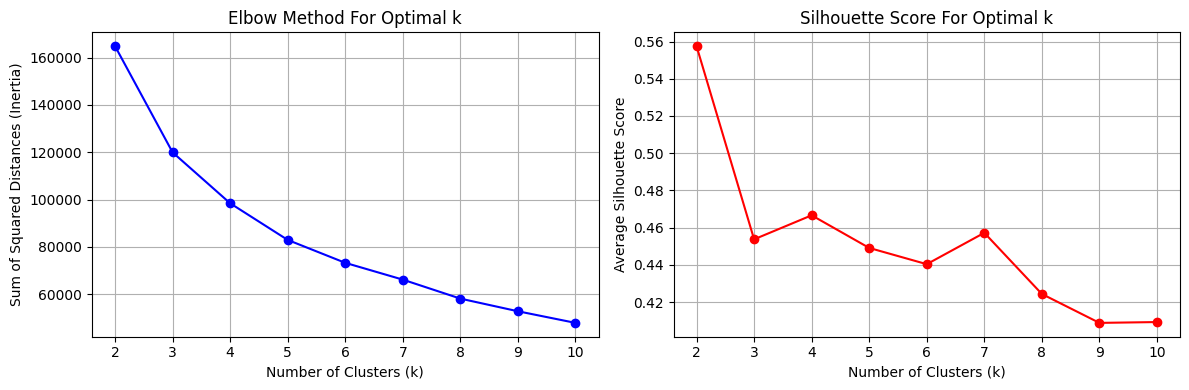


Performing final clustering with k=5-------
Clustering completed!
Silhouette Score for k=5: 0.449

--- Cluster Analysis ---
Number of restaurants per cluster:
cluster
0    17722
1    19868
2      996
3     5991
4     7140
Name: count, dtype: int64

Cluster Centroids (in original feature scale):
             rate  approx_cost(for two people)        votes  \
Cluster                                                       
0        3.624179                   435.140447    76.228078   
1        3.825257                   446.169720   178.562714   
2        4.418819                  1256.356356  4664.305305   
3        4.113577                  1301.202405   762.480294   
4        3.094846                   426.991036    76.752661   

         online_order_encoded  book_table_encoded  
Cluster                                            
0                4.207745e-14        5.078434e-04  
1                1.000000e+00        5.870304e-15  
2                5.395395e-01        6.156156e-01  
3

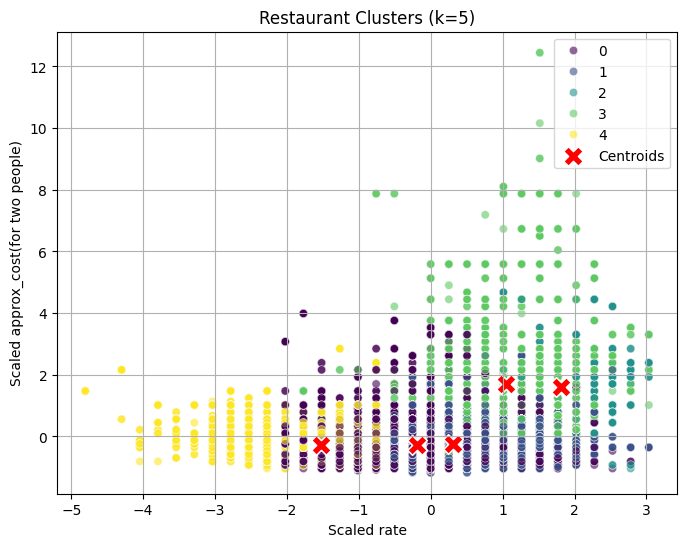


--- Sample Restaurants from Each Cluster ---

Cluster 0 (Sample Restaurants):
  - Green Mango Restaurant (Kerala, South Indian) - Cost: ₹300.0, Rating: 3.700000047683716
  - Bon Sante (Cafe, Continental, Italian) - Cost: ₹800.0, Rating: 3.5999999046325684
  - Spice It (North Indian, Continental, Italian) - Cost: ₹1200.0, Rating: 3.799999952316284

Cluster 1 (Sample Restaurants):
  - Fattoush (Arabian, Mughlai, Biryani, North Indian, Chinese, Seafood) - Cost: ₹900.0, Rating: 4.199999809265137
  - Flavors of India (North Indian, Chinese, Andhra) - Cost: ₹800.0, Rating: 3.5999999046325684
  - Jumping Beans (Cafe, North Indian, Chinese, Biryani, Beverages) - Cost: ₹850.0, Rating: 4.0

Cluster 2 (Sample Restaurants):
  - The Biere Club (Continental, BBQ, Finger Food) - Cost: ₹1700.0, Rating: 4.300000190734863
  - Hoot (Continental, Italian, North Indian) - Cost: ₹1400.0, Rating: 4.199999809265137
  - Communiti (Continental, BBQ, Salad) - Cost: ₹1500.0, Rating: 4.699999809265137

Cluster 3 

In [11]:
# --- 1. Determine Optimal Number of Clusters (Elbow Method & Silhouette) ---
print("Finding optimal number of clusters-----------")

# Define a range of cluster numbers to test
k_range = range(2, 11)
sum_of_squared_distances = [] # For Elbow Method
silhouette_scores = []       # For Silhouette Analysis

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sum_of_squared_distances.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    print(f"  k={k}, Inertia: {kmeans.inertia_:.2f}, Silhouette Score: {silhouette_avg:.3f}")

# Plot Elbow Method
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, sum_of_squared_distances, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 2. Choose k and Perform Final Clustering ---
optimal_k = 5 # <--- Adjust this based on your elbow/silhouette analysis ---
print(f"\nPerforming final clustering with k={optimal_k}-------")

final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# Add cluster labels back to the original dataframe
df['cluster'] = cluster_labels

print("Clustering completed!")
print(f"Silhouette Score for k={optimal_k}: {silhouette_score(X_scaled, cluster_labels):.3f}")

# --- 3. Analyze Clusters ---
print("\n--- Cluster Analysis ---")

# Show the number of restaurants in each cluster
print("Number of restaurants per cluster:")
print(df['cluster'].value_counts().sort_index())

# Show cluster centroids (in original feature space for interpretability)
centroids_scaled = final_kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

print("\nCluster Centroids (in original feature scale):")
centroid_df = pd.DataFrame(centroids_original, columns=feature_columns)
centroid_df.index.name = 'Cluster'
print(centroid_df)

# --- 4. Visualize Clusters (using first 2 features for simplicity) ---
print("\nGenerating cluster visualization-----")
plt.figure(figsize=(8, 6))

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=cluster_labels, palette='viridis', alpha=0.6)
# Plot centroids
sns.scatterplot(x=centroids_scaled[:, 0], y=centroids_scaled[:, 1], s=200, color='red', marker='X', label='Centroids')
plt.xlabel(f'Scaled {feature_columns[0]}')
plt.ylabel(f'Scaled {feature_columns[1]}')
plt.title(f'Restaurant Clusters (k={optimal_k})')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Inspect Sample Restaurants from Each Cluster ---
print("\n--- Sample Restaurants from Each Cluster ---")
for cluster_id in sorted(df['cluster'].unique()):
    print(f"\nCluster {cluster_id} (Sample Restaurants):")
    # Get a sample of restaurants from this cluster
    cluster_sample = df[df['cluster'] == cluster_id].sample(n=min(3, len(df[df['cluster'] == cluster_id])), random_state=42)
    for idx, row in cluster_sample.iterrows():
        print(f"  - {row['name']} ({row['cuisines']}) - Cost: ₹{row['approx_cost(for two people)']}, Rating: {row['rate']}")

In [12]:
print("\n--- Saving Clustering Results ---")

# 1. Save the KMeans model and other artifacts using pickle
import pickle

clustering_artifacts = {
    'kmeans_model': final_kmeans,  # The trained KMeans object
    'scaler': scaler,              # The scaler used (from KNN step)
    'feature_columns': feature_columns, # List of columns used for clustering
    'cluster_labels': cluster_labels,   # The labels assigned to each data point
    'optimal_k': optimal_k,        # The number of clusters chosen
    'centroids_original_scale': centroid_df
}

# Save the dictionary to a .pkl file
with open('restaurant_kmeans_clustering_model.pkl', 'wb') as f:
    pickle.dump(clustering_artifacts, f)

print("Clustering model and results saved to 'restaurant_clustering_model.pkl'")

# 2. Save the main dataframe with cluster labels to a new CSV
df.to_csv('zomato_restaurants_with_clusters.csv', index=False)
print("Dataset with cluster labels saved to 'zomato_restaurants_with_clusters.csv'")

print("\nClustering analysis complete and results saved!")


--- Saving Clustering Results ---
Clustering model and results saved to 'restaurant_clustering_model.pkl'
Dataset with cluster labels saved to 'zomato_restaurants_with_clusters.csv'

Clustering analysis complete and results saved!
